In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy as sc
import numpy.random as rn
import networkx as nx
import my_networkx as my_nx
import frame as frame
from numba import njit, prange

mpl.rcParams.update({'font.size': 25})

In [3]:
# size of network
N = 6

# adjacency matrix
A = np.array([[0, 1, 0, 1, 1, 0], [1, 0, 1, 0, 0, 1], [0, 1, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 1], [0, 1, 0, 0, 1, 0]])
frame.printMatrix(A)

0.00   1.00   0.00   1.00   1.00   0.00   

1.00   0.00   1.00   0.00   0.00   1.00   

0.00   1.00   0.00   0.00   0.00   0.00   

1.00   0.00   0.00   0.00   0.00   0.00   

1.00   0.00   0.00   0.00   0.00   1.00   

0.00   1.00   0.00   0.00   1.00   0.00   



In [4]:
# master operator, values from Rick in SuppMat
L = np.zeros((N, N))
# fill with values
L[0, 1] = 5.997
L[1, 0] = 0.774

L[0, 3] = 13.439
L[3, 0] = 127.968

L[0, 4] = 15.330
L[4, 0] = 0.121

L[4, 5] = 3.749
L[5, 4] = 13.326

L[1, 2] = 1514.820
L[2, 1] = 53.0661

L[1, 5] = 13.441
L[5, 1] = 2.922

L = L.T

#diagonal elements
for i in range(N):
    L[i,i] = -np.sum(L[:, i])


frame.printMatrix(L)

-34.77   0.77   0.00   127.97   0.12   0.00   

6.00   -1529.03   53.07   0.00   0.00   2.92   

0.00   1514.82   -53.07   0.00   0.00   0.00   

13.44   0.00   0.00   -127.97   0.00   0.00   

15.33   0.00   0.00   0.00   -3.87   13.33   

0.00   13.44   0.00   0.00   3.75   -16.25   



In [5]:
# find eigenvalues and eigenvectors
ew, ev = sc.linalg.eig(L)
print(ew)
# frame.printMatrix(ev)

# relevant eigenvector has eigenvalue 0
peq = ev[:, 4]
# print(peq)

# need to "normalise" it such that sum of entries is 1

Z = np.sum(peq)
# print(Z)
peq = peq / Z

print(np.sum(peq))

print(peq)

print(np.sort(np.abs(ew)))

[-1.58165132e+03+0.j -1.43749631e+02+0.j -1.98531625e+01+0.j
 -1.86991129e+01+0.j  7.96596241e-15+0.j -9.99871767e-01+0.j]
0.9999999999999998
[2.54859615e-03 1.97475509e-02 5.63711767e-01 2.67649597e-04
 3.22886823e-01 9.08376128e-02]
[7.96596241e-15 9.99871767e-01 1.86991129e+01 1.98531625e+01
 1.43749631e+02 1.58165132e+03]


In [6]:
# check for DB
for i in range(N):
    for j in range(N):
        if A[i, j] == 1:
            print("%.5f \t %.5f \t %.5f" % (L[i, j]*peq[j], L[j, i]*peq[i], L[j, i]*peq[i] / (L[i, j]*peq[j])))

0.01528 	 0.01528 	 0.99996
0.03425 	 0.03425 	 1.00000
0.03907 	 0.03907 	 1.00002
0.01528 	 0.01528 	 1.00004
29.91399 	 29.91399 	 1.00000
0.26543 	 0.26543 	 1.00000
29.91399 	 29.91399 	 1.00000
0.03425 	 0.03425 	 1.00000
0.03907 	 0.03907 	 0.99998
1.21050 	 1.21050 	 1.00000
0.26543 	 0.26543 	 1.00000
1.21050 	 1.21050 	 1.00000


In [7]:
# initial distribution
initial_p = np.array([0, 0, 0, 0, 0, 1])

# initialise class
system = frame.JumpProcessMasterEquation(N, initial_p, L, 100)

In [8]:
trajectories = []
trajectory_times = []


for i in range(50000):
    traj = system.Trajectory_sample(10)
    trajectories.append(traj[0])
    trajectory_times.append(traj[1])





In [9]:
print(np.shape(traj[0]), np.shape(traj[1]))

(270,) (271,)


In [10]:
p, t = system.empirical_probability(10, trajectories, trajectory_times)
p = np.array(p)


In [11]:
analytic = []

for k in t:
    analytic.append(system.master_eq_evolution(k))

analytic = np.array(analytic)

In [12]:
print(np.shape(analytic), np.shape(p), np.shape(t))
print(p[:, 1])

(100, 6) (100, 6) (100,)
[0.      0.00594 0.00666 0.00792 0.00922 0.01018 0.01274 0.01138 0.01314
 0.0129  0.0141  0.01514 0.01576 0.01474 0.01516 0.01674 0.01634 0.01712
 0.0173  0.01784 0.01826 0.01792 0.01768 0.01838 0.0176  0.01796 0.01966
 0.01892 0.01954 0.0188  0.01934 0.01874 0.01888 0.01944 0.0195  0.0197
 0.01816 0.0192  0.01912 0.01866 0.01982 0.01968 0.01832 0.01992 0.02004
 0.01986 0.019   0.01882 0.01906 0.01888 0.01966 0.02034 0.01944 0.01986
 0.0205  0.01948 0.01994 0.01934 0.02032 0.0192  0.01856 0.01988 0.02036
 0.02014 0.01888 0.01956 0.0196  0.01862 0.02064 0.02004 0.01954 0.02064
 0.01984 0.01966 0.02006 0.01932 0.02    0.0195  0.01866 0.01952 0.01922
 0.01924 0.01878 0.01996 0.01962 0.02028 0.01878 0.02052 0.0197  0.0201
 0.01924 0.01914 0.01972 0.0195  0.01976 0.01962 0.01894 0.0202  0.01924
 0.01982]


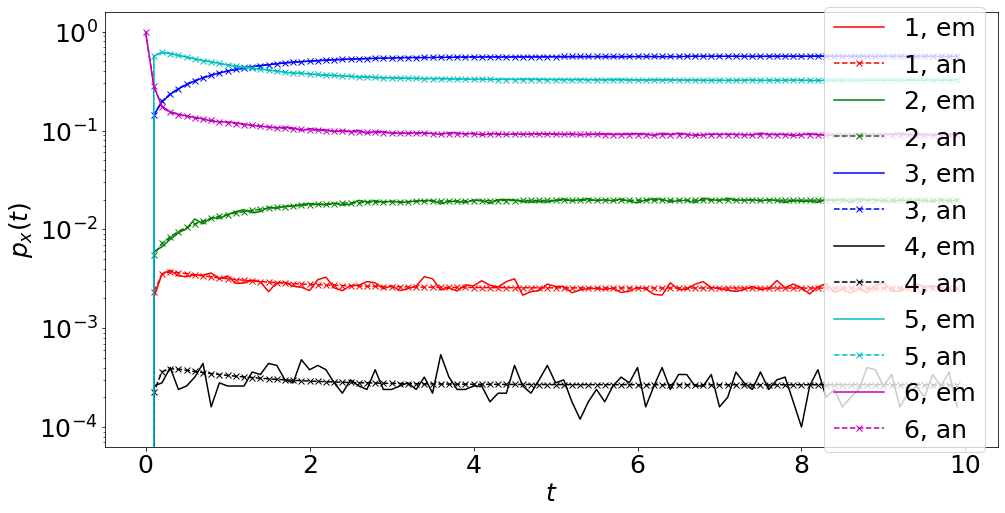

In [13]:
fig = plt.figure(figsize=(16, 8))

plt.plot(t, p[:, 0], "r-", label="1, em")
plt.plot(t, analytic[:, 0], "r--x", label="1, an")


plt.plot(t, p[:, 1], "g-", label="2, em")
plt.plot(t, analytic[:, 1], "g--x", label="2, an")


plt.plot(t, p[:, 2], "b-", label="3, em")
plt.plot(t, analytic[:, 2], "b--x", label="3, an")


plt.plot(t, p[:, 3], "k-", label="4, em")
plt.plot(t, analytic[:, 3], "k--x", label="4, an")


plt.plot(t, p[:, 4], "c-", label="5, em")
plt.plot(t, analytic[:, 4], "c--x", label="5, an")


plt.plot(t, p[:, 5], "m-", label="6, em")
plt.plot(t, analytic[:, 5], "m--x", label="6, an")


plt.yscale("log")
plt.xlabel(r"$t$")
plt.ylabel(r"$p_x(t)$")
plt.legend(loc="right")



In [14]:
# d_matrix = np.array([[0, 1, 0, 1, 1, 0], [-1, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0], [-1, 0, 0, 0, 0, 0], [-1, 0, 0, 0, 0, 1], [0, -1, 0, 0, -1, 0]])
d_matrix = np.array([[0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, -1], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, -1], [0, 1, 0, 0, 1, 0]])

frame.printMatrix(d_matrix)


0.00   0.00   0.00   0.00   0.00   0.00   

0.00   0.00   0.00   0.00   0.00   -1.00   

0.00   0.00   0.00   0.00   0.00   0.00   

0.00   0.00   0.00   0.00   0.00   0.00   

0.00   0.00   0.00   0.00   0.00   -1.00   

0.00   1.00   0.00   0.00   1.00   0.00   



In [15]:
def empirical_current_timeindependent(traj, d_matrix, traj_time, maxtime=10):
    J = np.zeros(len(traj))
    
    for k in range(len(traj)):
        for i in range(len(traj[k])-1):
            # print(k, i, len(traj_time), len(traj_time[k]), len(traj[k]))
            if traj_time[k][i] < maxtime:
                # print(traj[k][i]-1, traj[k][i+1]-1)       
                J[k] += d_matrix[traj[k][i]-1, traj[k][i+1]-1]
                
    return J

def analytic_mean_current(d_matrix, L, final_time, number_times):
    """_summary_

    Args:
        d_matrix (_type_): d matrix
        L (_type_): master operator
        final_time (_type_): final time
        number_times (_type_): number of time steps 

    Returns:
        _type_: _description_
    """ 

    dt = final_time / number_times

    avg_J = 0

    for m in range(number_times):
        p_an = system.master_eq_evolution(m*dt)
        
        for i in range(len(p_an)):
            for j in range(len(p_an)):
                if i != j:
                    avg_J += dt * p_an[i] * d_matrix[i, j] * L[j, i]


    return avg_J


def analyt_entropy(L, final_time, number_times, Adj):

    dt = final_time / number_times

    S = 0

    for m in range(number_times):
        p_an = system.master_eq_evolution((m+1)*dt)
        
        for i in range(len(p_an)):
            for j in range(len(p_an)):
                if Adj[i, j] == 1:
                    S += dt * p_an[i] *  L[j, i] * np.log((p_an[i] *  L[j, i]) / (p_an[j] *  L[i, j]))

    return S


In [16]:
Jcurr = empirical_current_timeindependent(trajectories, d_matrix, trajectory_times, 1.5)

k = np.where(np.array(trajectory_times[0]) < 1.5)

print(Jcurr[0])
print(np.array(trajectories[0])[k])
print(np.array(trajectory_times[0])[k])



# print(np.mean(Jcurr), analytic_mean_current(d_matrix, L, 2, 200))

# plt.hist(Jcurr)
# print(np.histogram(Jcurr))
# print(100 / 5000)

# plt.bar(x = np.arange(1, 7), height=system.master_eq_evolution(0.1))

1.0
[6 5 6 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3
 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3]
[0.         0.06104532 0.90907479 0.96104485 0.96215967 0.9967164
 0.99791972 1.01947508 1.02016742 1.02935615 1.02937773 1.08712366
 1.08935773 1.09242544 1.09243229 1.13820192 1.13828064 1.14496309
 1.14507456 1.15543084 1.15659469 1.16859104 1.16922573 1.19266261
 1.19277032 1.19435988 1.19525266 1.20856435 1.20907737 1.21377736
 1.2137797  1.25001538 1.25047417 1.25181865 1.25238285 1.25382217
 1.25390518 1.26381712 1.26404256 1.26660461 1.26741666 1.27047244
 1.27075175 1.27180315 1.27260318 1.28512632 1.28562062 1.33598038
 1.33664561 1.33868807 1.33879595 1.33917297 1.34008832 1.34747832
 1.34756609 1.35640004 1.3570234  1.3624658  1.36349891 1.36901378
 1.36912223 1.37451929 1.37570784 1.38502983 1.38808269 1.43941253
 1.44029101 1.49291355 1.49319855 1.49750356 1.49783334]


In [17]:
A = np.array([[0, 1, 0, 1, 1, 0], [1, 0, 1, 0, 0, 1], [0, 1, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 1], [0, 1, 0, 0, 1, 0]])


print(analyt_entropy(L, 10, 10000, A) / 2, np.mean(Jcurr) ** 2 /np.var(Jcurr), np.mean(Jcurr), np.var(Jcurr))

1.1691842623221913 1.5274225344993175 0.60434 0.2391131644


In [18]:
def test_plot(A, L, d_matrix, number_different_sample=5, maximal_time=10, number_timesteps=100, trajectories_per_sample=100):
    J_mean_emp = np.zeros((number_different_sample, number_timesteps-1))
    J_var_emp = np.zeros((number_different_sample, number_timesteps-1))
    J_mean_an = np.zeros(number_timesteps-1) 
    Entropy = np.zeros(number_timesteps-1)

    dJ_mean_emp = np.zeros((number_different_sample, number_timesteps-2))
    dJ_mean_an = np.zeros(number_timesteps-2)

    dt = maximal_time / number_timesteps

    time = []

    # take different realisations 
    for i in range(number_different_sample):
        trajectories = []
        trajectory_times = []

        # sample trajectories in each realisation
        for j in range(trajectories_per_sample):
            traj = system.Trajectory_sample(maximal_time)
            trajectories.append(traj[0])
            trajectory_times.append(traj[1])
            # print(np.shape(traj[0]), np.shape(traj[1]))
        
        for t in range(1, number_timesteps):
            Jc = empirical_current_timeindependent(trajectories, d_matrix, trajectory_times, t*dt)
            J_mean_emp[i, t-1] = np.mean(Jc)
            #J_var_emp[i, t-1] = np.var(Jc)

            if i == 0:
                J_mean_an[t-1] = analytic_mean_current(d_matrix, L, t*dt, 1000)
                # Entropy[t-1] = analyt_entropy(L, t*dt, 1000, A)
                time.append(t*dt)

        print(i)

    for i in range(number_different_sample):
        dJ_mean_emp[i][:] = (J_mean_emp[i, 1:] - J_mean_emp[i, :-1])/dt
        dJ_mean_an[:] = (J_mean_an[1:] - J_mean_an[:-1])/dt

    return J_mean_an, J_mean_emp, time#, J_var_emp, Entropy, dJ_mean_an, dJ_mean_emp

        


In [19]:
d_matrix = np.array([[0, 1, 0, 0, 0, 0], [-1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0]])

frame.printMatrix(d_matrix)

J_mean_an, J_mean_emp, time = test_plot(A, L, d_matrix, 1, 10, 200, 5000)
# J_mean_an, J_mean_emp, J_var_emp, Entropy, dJ_mean_an, dJ_mean_emp, time = test_plot(A, L, d_matrix, 5, 10, 200, 1000)

0.00   1.00   0.00   0.00   0.00   0.00   

-1.00   0.00   0.00   0.00   0.00   0.00   

0.00   0.00   0.00   0.00   0.00   0.00   

0.00   0.00   0.00   0.00   0.00   0.00   

0.00   0.00   0.00   0.00   0.00   0.00   

0.00   0.00   0.00   0.00   0.00   0.00   

0


In [64]:
from numba import jit
# @jit
def empirical_current_timeindependent_2(traj, d_matrix, traj_time, maxtime=10, size=200):
    N = len(traj)
    J = np.zeros((N, size-1))
    
    dt = maxtime / size
    for k in range(N):
        if k%1000 == 0:
            print(k)
        for s in range(1, size):
            ind = np.where(np.array(traj_time[k]) < dt * s)[0]
            # print(ind, ind+1, len(traj[k]))
            if len(ind) > 1 and len(ind) < len(traj[k]) - 1:
                k1 = np.array(traj[k])[ind]-1
                k2 = np.array(traj[k])[ind+1]-1
                #print(k1, k2)
                #print(np.array(traj[k])[ind+1]-1, len(np.array(traj[k])[ind+1]-1))
                #print(d_matrix[np.array(traj[k])[ind+1]-1])
                J[k, s-1] += np.sum(d_matrix[k1, k2])
            #if k == 0:
            #    print(tra_val)
            #    print(np.array(traj[k])[ind])
            #    print(d_matrix[np.array(traj[k])[ind]-1, np.array(traj[k])[ind+1]-1])
            #    print(np.array(traj_time[k])[ind], dt * s)
            #    print("***********************************************")
            

    mean_J = np.zeros(size-1)
    var_J = np.zeros(size-1)
    for i in range(size - 1):
        mean_J[i] = np.mean(J[:, i])
        var_J[i] = np.std(J[:, i])
    return J, mean_J, var_J



Jtest2, Jtest2_mean, Jtest2_var = empirical_current_timeindependent_2(trajectories, d_matrix=d_matrix, traj_time=trajectory_times, maxtime=10, size=200)


#Jtest = []
#for t in time:
#    Jtest.append(np.mean(empirical_current_timeindependent(trajectories, d_matrix, trajectory_times, t)))



0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000


[0.00024 0.0007  0.00148 0.00224 0.0029  0.00378 0.00456 0.0052  0.00572
 0.00686 0.00774 0.0082  0.00862 0.0092  0.00972 0.0103  0.0106  0.01128
 0.0119  0.01218 0.01258 0.01284 0.01304 0.0133  0.01344 0.01368 0.01382
 0.01378 0.01416 0.0145  0.01472 0.01506 0.01516 0.01562 0.0155  0.01578
 0.01576 0.0158  0.01622 0.01608 0.01616 0.0162  0.01634 0.0168  0.0169
 0.0174  0.01736 0.01716 0.01724 0.0169  0.01716 0.01704 0.01698 0.0173
 0.01758 0.0179  0.0179  0.01826 0.01852 0.01858 0.01846 0.01854 0.01858
 0.01846 0.01844 0.01828 0.01834 0.01844 0.01856 0.01852 0.0186  0.01838
 0.01866 0.01862 0.01868 0.01878 0.019   0.01894 0.01888 0.01868 0.01888
 0.0193  0.01914 0.01916 0.0192  0.0189  0.01894 0.01898 0.01902 0.01926
 0.01914 0.01918 0.01904 0.01908 0.01886 0.0187  0.01878 0.0191  0.01914
 0.0192  0.01906 0.01902 0.01894 0.01886 0.01904 0.01882 0.01874 0.01864
 0.01864 0.01844 0.01824 0.01848 0.01854 0.01846 0.0184  0.01834 0.01842
 0.01846 0.01844 0.0187  0.01902 0.01906 0.01908 0.01

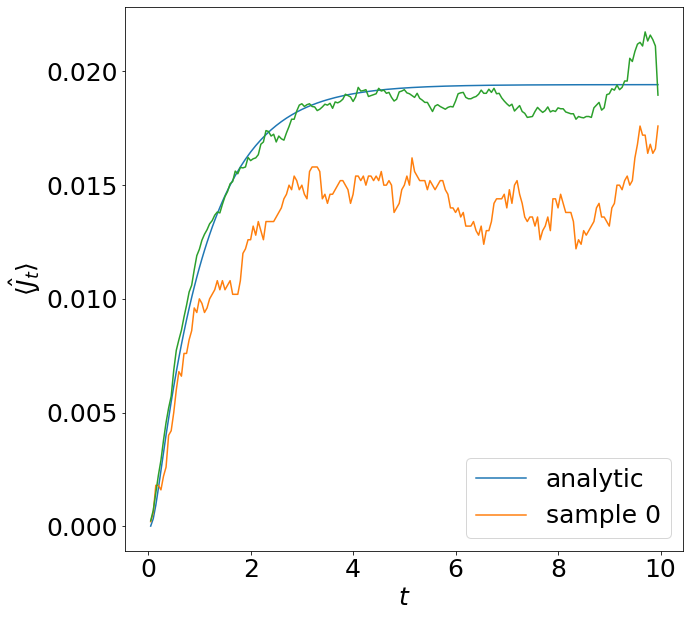

In [66]:
print((Jtest2_mean))
fig = plt.figure(figsize=(10, 10))


plt.plot(time, J_mean_an, label="analytic")
for i in range(1):
    plt.plot(time, J_mean_emp[i], label="sample %d" %i)
plt.plot(time, Jtest2_mean)
#plt.fill_between(time, Jtest2_mean-Jtest2_var, Jtest2_mean+Jtest2_var,
#    alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')

plt.xlabel(r"$t$")
plt.ylabel(r"$\langle \hat{{J}}_t\rangle$")
plt.legend()

In [190]:
print(Jtest)

[0.0002, 0.001, 0.0021, 0.0033, 0.004, 0.0052, 0.0063, 0.0072, 0.0077, 0.0081, 0.0086, 0.0094, 0.0097, 0.0105, 0.0105, 0.0108, 0.0112, 0.0112, 0.011, 0.0119, 0.0124, 0.0123, 0.0125, 0.0128, 0.0127, 0.0126, 0.0122, 0.0121, 0.0129, 0.0133, 0.014, 0.0141, 0.0142, 0.0143, 0.014, 0.0142, 0.0141, 0.0142, 0.014, 0.0139, 0.0135, 0.0135, 0.0138, 0.0141, 0.0141, 0.0142, 0.0147, 0.0147, 0.0152, 0.0155, 0.0153, 0.0151, 0.0149, 0.015, 0.015, 0.0151, 0.0155, 0.0157, 0.015, 0.015, 0.0148, 0.0153, 0.0154, 0.0151, 0.0149, 0.0151, 0.0151, 0.015, 0.0144, 0.0143, 0.0146, 0.0149, 0.0153, 0.0155, 0.0155, 0.015, 0.0146, 0.0146, 0.015, 0.0146, 0.015, 0.0155, 0.0152, 0.0157, 0.015, 0.015, 0.0151, 0.0154, 0.0156, 0.0158, 0.0156, 0.0154, 0.0158, 0.0164, 0.0165, 0.0166, 0.0164, 0.0163, 0.0162, 0.0158, 0.0159, 0.0159, 0.0161, 0.0162, 0.0161, 0.0168, 0.0167, 0.0175, 0.0178, 0.0175, 0.0177, 0.0173, 0.0173, 0.0173, 0.0176, 0.0179, 0.0177, 0.0181, 0.0179, 0.0183, 0.018, 0.0186, 0.0187, 0.019, 0.0199, 0.0196, 0.0192, 0

In [116]:
d_matrix = np.array([[0, 1, 0, 1, 1, 0], [-1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [-1, 0, 0, 0, 0, 0], [-1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0]])

frame.printMatrix(d_matrix)

J_mean_an1, J_mean_emp1, J_var_emp1, Entropy1, dJ_mean_an1, dJ_mean_emp1, time1 = test_plot(A, L, d_matrix, 5, 10, 200, 1000)

0.00   1.00   0.00   1.00   1.00   0.00   

-1.00   0.00   0.00   0.00   0.00   0.00   

0.00   0.00   0.00   0.00   0.00   0.00   

-1.00   0.00   0.00   0.00   0.00   0.00   

-1.00   0.00   0.00   0.00   0.00   0.00   

0.00   0.00   0.00   0.00   0.00   0.00   

0
1
2
3
4


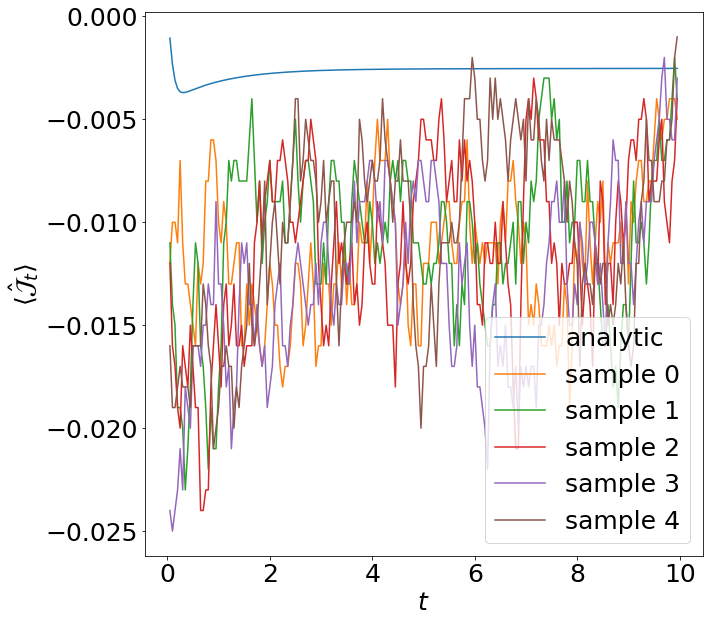

In [117]:
fig = plt.figure(figsize=(10, 10))


plt.plot(time, J_mean_an1, label="analytic")
for i in range(5):
    plt.plot(time, J_mean_emp1[i], label="sample %d" %i)


plt.xlabel(r"$t$")
plt.ylabel(r"$\langle \hat{\mathcal{J}}_t\rangle$")
plt.legend()

In [121]:
d_matrix = np.array([[0, 1, 0, 1, 1, 0], [-1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [-1, 0, 0, 0, 0, 0], [-1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0]])

frame.printMatrix(d_matrix)

J_mean_an2, J_mean_emp2, J_var_emp2, Entropy2, dJ_mean_an2, dJ_mean_emp2, time2 = test_plot(A, L, d_matrix, 5, 10, 200, 200)

0.00   1.00   0.00   1.00   1.00   0.00   

-1.00   0.00   0.00   0.00   0.00   0.00   

0.00   0.00   0.00   0.00   0.00   0.00   

-1.00   0.00   0.00   0.00   0.00   0.00   

-1.00   0.00   0.00   0.00   0.00   0.00   

0.00   0.00   0.00   0.00   0.00   0.00   

0
1
2
3
4


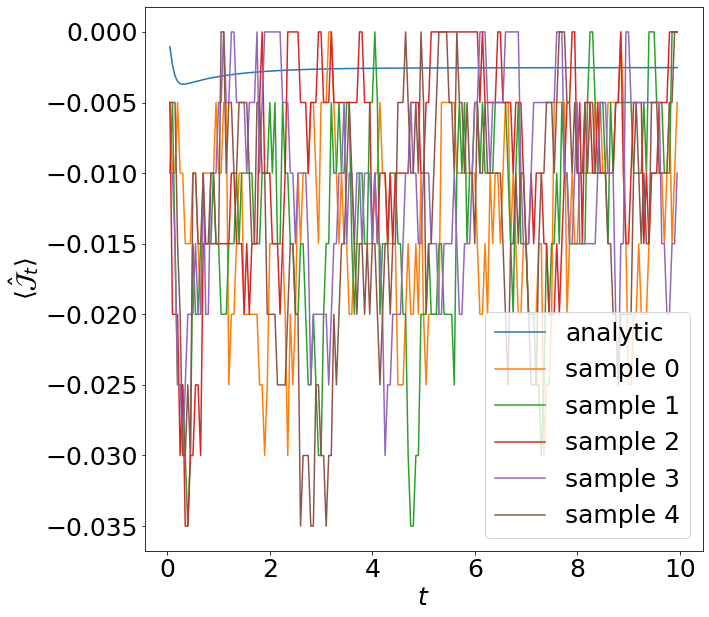

In [122]:
fig = plt.figure(figsize=(10, 10))


plt.plot(time, J_mean_an2, label="analytic")
for i in range(5):
    plt.plot(time, J_mean_emp2[i], label="sample %d" %i)


plt.xlabel(r"$t$")
plt.ylabel(r"$\langle \hat{\mathcal{J}}_t\rangle$")
plt.legend()